In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
ds = xr.open_dataset('PMSL_20102019.nc')

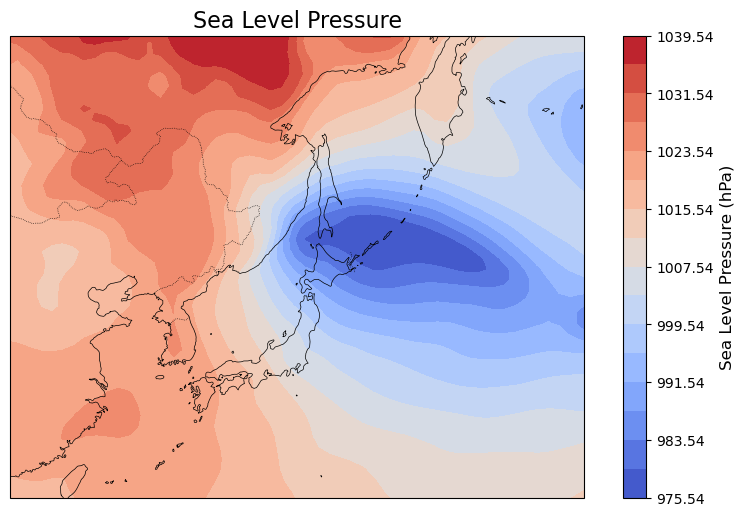

In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

PMSL = ds.PMSL[0] / 100  # Convert to hPa if values are in Pa

# Extract lat2d and lon2d
lat2d = PMSL['lat2d'].values
lon2d = PMSL['lon2d'].values

# Define the Lambert Conformal projection for plotting
projection = ccrs.LambertConformal(
    central_longitude=142, 
    central_latitude=35, 
    standard_parallels=(20,65) )

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': projection})
ax.set_extent([115, 165, 25, 60], crs=ccrs.PlateCarree()) 

# Add map features
ax.coastlines(lw=.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', lw=.5)
ax.add_feature(cfeature.LAND, edgecolor='black', lw=.5)

# Define contour levels and plot PMSL
levels = np.arange(PMSL.min(), PMSL.max()+3, 4)  # Define levels with 2 hPa intervals
contourf = ax.contourf(lon2d, lat2d, PMSL, levels=levels, cmap='coolwarm', transform=ccrs.PlateCarree())

# Add a color bar
cbar = plt.colorbar(contourf, ax=ax, orientation='vertical', pad=0.05)
cbar.set_label('Sea Level Pressure (hPa)', fontsize=12)

# Title
ax.set_title('Sea Level Pressure', fontsize=16)

# Show the plot
plt.show()


In [4]:
from ssom import SSOM

In [5]:
som = SSOM(grid_size=(10, 10), num_iterations=5000, grid_shape="2D", metric='ssim')

SSOM Initial Settings:
  Grid Shape: 2D
  Grid Size: 10x10
  Number of Iterations: 5000
  Max Learning Rate: 0.1
  Learning Decay: 0.25
  Neighborhood Decay: 0.5
  Metric: ssim
  Log Interval: 50



In [6]:
pmsl = ds.PMSL
shape = pmsl.shape

In [7]:
som_input = pmsl.stack(lat_lon=('lat', 'lon')).values / 100

In [8]:
som.train(som_input)

Initialized SOM grid with random weights.
Iter 5000/5000 [==================================================]  LearnRate: 0.0018


In [9]:
som_output = som.som_grid

In [10]:
somout2D = som_output.reshape(10, 10, shape[1], shape[2])

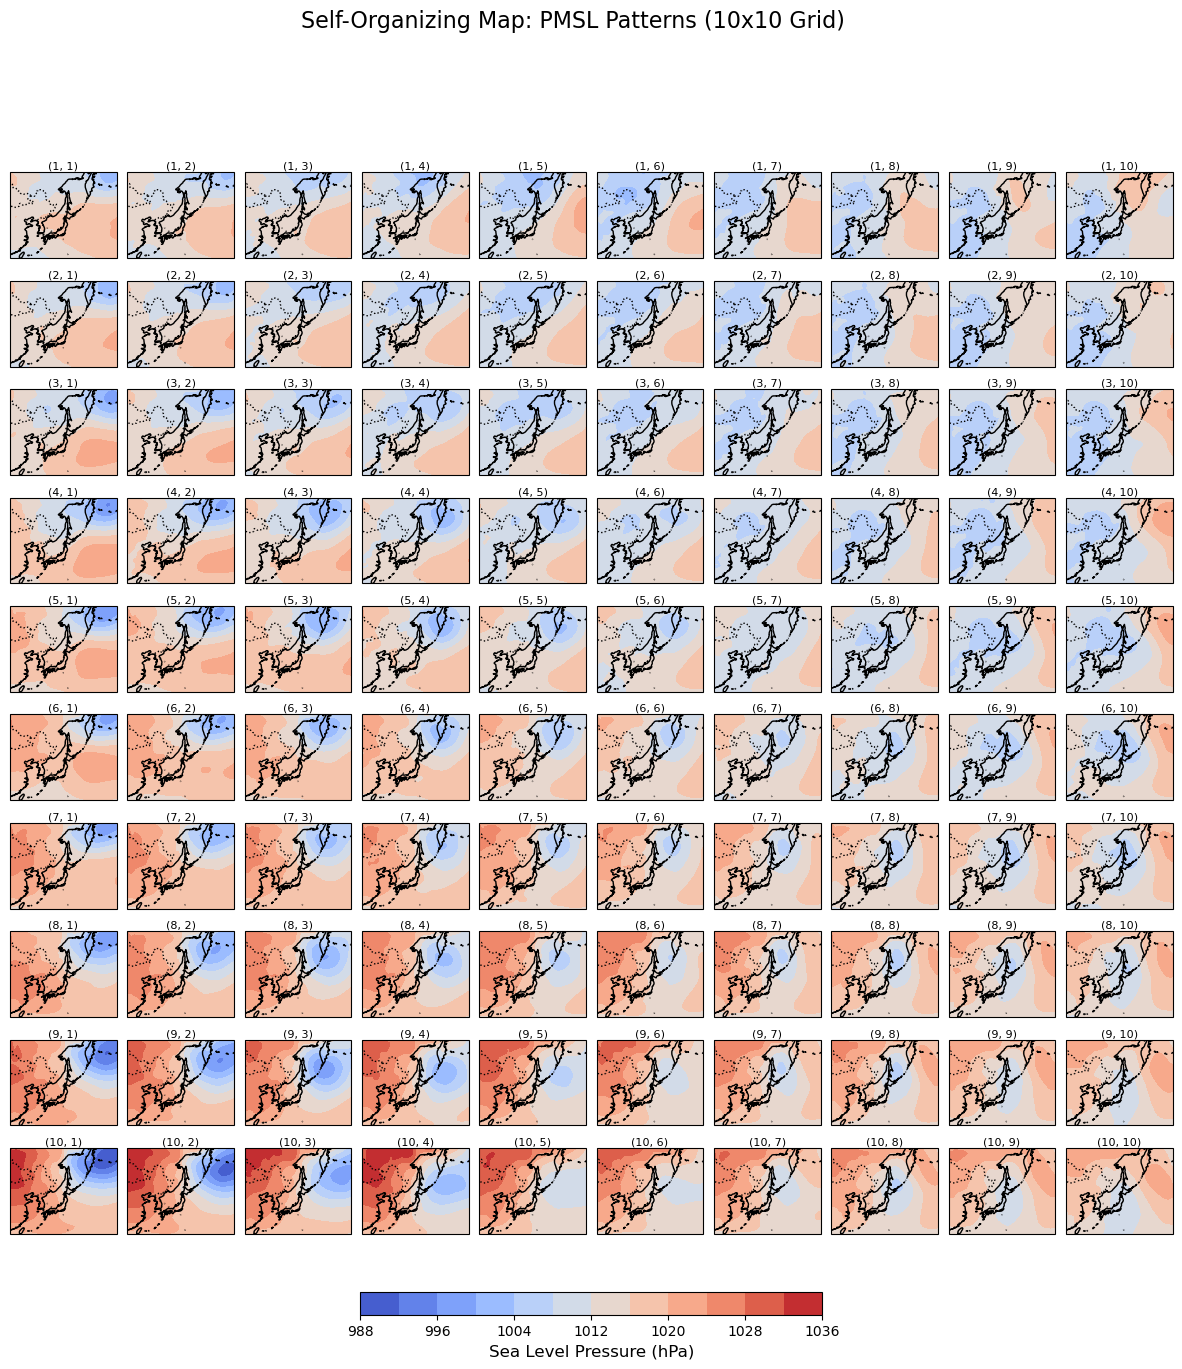

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.gridspec import GridSpec

lon2d = pmsl.lon2d  # Replace with longitude array
lat2d = pmsl.lat2d  # Replace with latitude array

# Define constants
central_lon = 142.0
central_lat = 35.0
extent = [115, 165, 25, 60]  # Japan region
std_parallels = (20, 65)

# Compute global min and max values across all SOM nodes
global_min = np.min(somout2D)
global_max = np.max(somout2D)
levels = np.arange(np.floor(global_min), np.ceil(global_max) + 3, 4)  # Adjust step size as needed

# Define the Lambert Conformal projection
projection = ccrs.LambertConformal(
    central_longitude=central_lon, 
    central_latitude=central_lat, 
    standard_parallels=std_parallels
)

# Create a 10x10 grid of subplots with closer spacing using GridSpec
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(10, 10, figure=fig, wspace=0.1, hspace=0.1)  # Adjust wspace and hspace for tighter spacing

# Variable to hold the last contourf plot for the color bar
last_contourf = None

for i in range(10):
    for j in range(10):
        ax = fig.add_subplot(gs[i, j], projection=projection)

        # Add map features
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.add_feature(cfeature.LAND, edgecolor='black')
        ax.set_extent(extent, crs=ccrs.PlateCarree())  # Set map extent

        # Get PMSL for the current SOM node
        pmsl_node = somout2D[i, j]

        # Define filled contour levels and plot with a color map
        last_contourf = ax.contourf(lon2d, lat2d, pmsl_node, levels=levels, cmap='coolwarm', transform=ccrs.PlateCarree())
        
        # Add a title for each subplot
        ax.set_title(f'({i+1}, {j+1})', fontsize=8, pad=2)

# Add a single colorbar for all plots
cbar = fig.colorbar(last_contourf, ax=fig.axes, orientation='horizontal', fraction=0.02, pad=0.05)
cbar.set_label('Sea Level Pressure (hPa)', fontsize=12)

# Set the overall title
fig.suptitle('Self-Organizing Map: PMSL Patterns (10x10 Grid)', fontsize=16)
plt.savefig('fig/weather_pattern.png', dpi=150)
# Show the plot
plt.show()
